# Detección de Vehículos con YOLOv8 (objetos)

El presente trabajo tiene como objetivo aplicar técnicas avanzadas de visión artificial mediante el uso del modelo YOLOv8, uno de los más recientes y potentes algoritmos para detección en tiempo real. Se ha entrenado este modelo sobre un conjunto de imágenes etiquetadas manualmente, que contienen diversas clases de vehículos: coches, bicicletas, aviones, barcos, etc.



El proyecto aborda desde la preparación del conjunto de datos, pasando por el entrenamiento del modelo, hasta la evaluación de su rendimiento y pruebas sobre imágenes nuevas.



#### El Yolov 8 es un modelo de detección de objetos porque:

Localiza objetos: predice coordenadas exactas (cajas delimitadoras o bounding boxes) para cada objeto detectado en la imagen.

Clasifica objetos: asigna una etiqueta (clase) a cada uno de esos objetos detectados, como "car", "person", "bicycle", etc.

###  Importación de librerías y configuración general

Se utilizan las librerías de Ultralytics para la arquitectura YOLOv8, así como herramientas clásicas como matplotlib, pandas y opencv para visualización, análisis y manipulación de imágenes.


In [12]:
# Importar librerías necesarias
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import shutil


In [8]:
# Directorio base donde están las carpetas de cada clase
BASE_DIR = 'data/vehicle/Vehicles'

# Lista de clases (carpetas dentro de BASE_DIR)
# Solo incluir carpetas reales (ignoramos archivos como .DS_Store)
CLASSES = sorted([d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))])


# Mostrar clases detectadas
print("Clases detectadas:", CLASSES)


Clases detectadas: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


### Generación Automática de Anotaciones (Bounding Boxes)

Es necesario disponer de archivos de anotaciones que indiquen las posiciones y clases de los objetos presentes en cada imagen. En esta etapa, creamos anotaciones simuladas, donde cada imagen es etiquetada con una bounding box que cubre toda su extensión.

Esto se realiza para facilitar una fase de prueba inicial del modelo, aunque en escenarios reales sería preferible contar con anotaciones precisas generadas manualmente o mediante herramientas automáticas más avanzadas.

In [9]:
# Crear anotaciones falsas (bounding box alrededor de todo el objeto en cada imagen)
for cls in CLASSES:
    cls_dir = os.path.join(BASE_DIR, cls)
    images = [img for img in os.listdir(cls_dir) if img.endswith(('.jpg', '.png'))]

    for img_file in images:
        img_path = os.path.join(cls_dir, img_file)
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        # Bounding box ocupa toda la imagen (en formato YOLO: x_center, y_center, width, height normalizados)
        x_center, y_center = 0.5, 0.5
        width, height = 1.0, 1.0
        class_id = CLASSES.index(cls)

        # Asignar aleatoriamente a train o val
        split = "train" if np.random.rand() > 0.2 else "val"
        label_dir = f"dataset/labels/{split}"
        os.makedirs(label_dir, exist_ok=True)

        # Guardar el archivo .txt con la anotación
        txt_path = os.path.join(label_dir, f"{cls}_{os.path.splitext(img_file)[0]}.txt")
        with open(txt_path, "w") as f:
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")


libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


In [13]:
# Crear carpetas para las imágenes
for split in ['train', 'val']:
    os.makedirs(f'dataset/images/{split}', exist_ok=True)

# Sincronizar imágenes con sus correspondientes anotaciones
for cls in CLASSES:
    cls_dir = os.path.join(BASE_DIR, cls)
    images = [img for img in os.listdir(cls_dir) if img.endswith(('.jpg', '.png'))]

    for img_file in images:
        split = "train" if os.path.exists(f"dataset/labels/train/{cls}_{os.path.splitext(img_file)[0]}.txt") else "val"
        src_img_path = os.path.join(cls_dir, img_file)
        dst_img_path = f"dataset/images/{split}/{cls}_{img_file}"

        shutil.copy2(src_img_path, dst_img_path)



#### YOLOv8 requiere un archivo de configuración data.yaml que indique:

La ruta a las imágenes de entrenamiento (train)

La ruta a las imágenes de validación (val)

El número de clases (nc)

Los nombres de cada clase (names)

In [ ]:
# Obtener rutas absolutas
train_img_path = os.path.abspath("dataset/images/train")
val_img_path = os.path.abspath("dataset/images/val")

# Generar archivo data.yaml con rutas absolutas
data_yaml_content = f"""
train: {train_img_path}
val: {val_img_path}

nc: {len(CLASSES)}
names: {CLASSES}
"""

with open("dataset/data.yaml", "w") as f:
    f.write(data_yaml_content)

print("✅ Archivo dataset/data.yaml creado con rutas absolutas.")


✅ Archivo dataset/data.yaml creado con rutas absolutas.


En este paso se carga el modelo base yolov8s.pt, un modelo preentrenado ligero que sirve como punto de partida para el aprendizaje transferido. 
Luego, se entrena con los datos personalizados definidos en el archivo data.yaml.

In [17]:
 # Cargar el modelo base y entrenar
model = YOLO("yolov8s.pt")  # Puedes usar yolov8n.pt para modelos más ligeros

# Entrenamiento
model.train(
    data="dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="vehicle_detector",
    patience=10,         # early stopping si no mejora
    verbose=True
)


Ultralytics 8.3.128 🚀 Python-3.9.22 torch-2.7.0 CPU (Apple M1 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicle_detector2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fa

train: Scanning /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/labels/train... 4414 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4414/4414 [00:01<00:00, 2877.90it/s]

train: /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/images/train/Ships_Ship (773).jpg: corrupt JPEG restored and saved
train: New cache created: /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 380.6±313.9 MB/s, size: 97.2 KB)


val: Scanning /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/labels/val... 1090 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1090/1090 [00:00<00:00, 2635.09it/s]

val: /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/images/val/Planes_Plane (93).jpg: corrupt JPEG restored and saved
val: /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/images/val/Ships_Ship (757).jpg: corrupt JPEG restored and saved
val: /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/images/val/Ships_Ship (790).jpg: corrupt JPEG restored and saved
val: New cache created: /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/labels/val.cache
Plotting labels to runs/detect/vehicle_detector2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/vehicle_detector2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.661      8.941      2.026         49        640:   1%|          | 2/276 [00:29<1:07:57, 14.88s/it]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
       1/50         0G      1.594      8.619      1.998         49        640:   1%|          | 3/276 [00:43<1:06:07, 14.53s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       1/50         0G      1.475      7.561      1.902         50        640:   4%|▎         | 10/276 [02:24<1:03:44, 14.38s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       1/50         0G      1.208      5.928      1.702         55        640:   7%|▋         | 20/276 [04:51<1:02:26, 14.64s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       1/50         0G      0.301      1.689      1.037         52        640:  63%|██████▎   | 174/276 [40:26<23:24, 13.77s/it] libpng warning: iCCP: 

                   all       1090       1090      0.865      0.814      0.901      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.1585     0.8041     0.9202         47        640:  14%|█▍        | 38/276 [08:54<54:23, 13.71s/it]  libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       2/50         0G      0.181     0.7778     0.9331         49        640:  52%|█████▏    | 144/276 [33:59<31:56, 14.52s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       2/50         0G     0.1801     0.7747     0.9312         55        640:  59%|█████▉    | 163/276 [38:38<27:26, 14.57s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       2/50         0G     0.1787     0.7737     0.9302         45        640:  71%|███████   | 196/276 [46:36<18:34, 13.93s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       2/50         0G     0.1776     0.7701     0.9281         48        640:  85%|████████▌ | 235/276 [55:17<08:59, 13.16s/it]libpng warning: iCCP: profile 'ICC Prof

                   all       1090       1090      0.826      0.864      0.936      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.1707     0.7651     0.9151         55        640:  11%|█         | 29/276 [06:49<58:52, 14.30s/it]  libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
       3/50         0G     0.1693     0.7434     0.9151         58        640:  13%|█▎        | 36/276 [08:29<56:55, 14.23s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       3/50         0G     0.1696     0.7251     0.9165         53        640:  33%|███▎      | 92/276 [21:28<41:02, 13.39s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       3/50         0G     0.1699     0.7233     0.9163         46        640:  34%|███▍      | 95/276 [22:08<39:54, 13.23s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       3/50         0G      0.173     0.7389     0.9205         51        640:  50%|████▉     | 137/276 [31:48<32:58, 14.23s/it]libpng warning: iCCP: profi

                   all       1090       1090      0.764      0.822      0.907      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.1747     0.6413     0.9328         46        640:  10%|▉         | 27/276 [06:24<58:43, 14.15s/it]  libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       4/50         0G     0.1746     0.6693     0.9338         52        640:  19%|█▉        | 52/276 [12:18<51:42, 13.85s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       4/50         0G     0.1692     0.6812     0.9278         57        640:  28%|██▊       | 76/276 [17:54<46:42, 14.01s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       4/50         0G      0.166     0.6935      0.925         45        640:  35%|███▌      | 97/276 [22:45<40:48, 13.68s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       4/50         0G     0.1625      0.686     0.9196         46        640:  50%|█████     | 138/276 [32:22<33:10, 14.43s/it]libpng warning: iCCP: profile 'ICC Profile

                   all       1090       1090      0.883        0.9      0.954      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.1494     0.5884      0.925         50        640:   3%|▎         | 7/276 [01:38<1:03:30, 14.17s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       5/50         0G     0.1415     0.5678     0.9128         54        640:   3%|▎         | 9/276 [02:04<1:01:13, 13.76s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       5/50         0G     0.1407     0.5953     0.9104         47        640:   9%|▉         | 26/276 [06:09<59:50, 14.36s/it]  libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       5/50         0G     0.1434     0.6219     0.9076         51        640:  16%|█▌        | 44/276 [10:20<54:32, 14.10s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       5/50         0G     0.1447     0.6349     0.9035         53        640:  30%|███       | 83/276 [19:33<43:40, 13.58s/it]libpng warning: iCCP: profile 'ICC Profil

                   all       1090       1090      0.912      0.935      0.972      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.1316     0.5323     0.9004         58        640:   9%|▉         | 25/276 [06:04<59:00, 14.10s/it]  libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
       6/50         0G     0.1273     0.5254     0.9019         48        640:  15%|█▍        | 41/276 [10:01<59:02, 15.08s/it]  libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       6/50         0G     0.1324     0.5508     0.9076         57        640:  20%|█▉        | 54/276 [13:08<53:59, 14.59s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       6/50         0G     0.1358     0.5583     0.9065         48        640:  31%|███       | 86/276 [26:15<4:21:59, 82.73s/it] libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       6/50         0G     0.1361     0.5616     0.9062         51        640:  32%|███▏      | 88/276 [26:43<2:29:34, 47.74s/it]libpng warning: iCCP:

                   all       1090       1090      0.909      0.919      0.966      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.1191     0.4996     0.8922         51        640:  13%|█▎        | 37/276 [08:52<57:08, 14.34s/it]  libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       7/50         0G      0.121     0.5177      0.892         53        640:  27%|██▋       | 75/276 [17:53<46:54, 14.00s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       7/50         0G     0.1214     0.5196     0.8954         51        640:  39%|███▉      | 108/276 [25:35<39:23, 14.07s/it]libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
       7/50         0G     0.1212     0.5175     0.8961         54        640:  46%|████▋     | 128/276 [30:11<34:09, 13.85s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       7/50         0G     0.1194     0.5235     0.8971         45        640:  74%|███████▍  | 205/276 [2:11:36<1:08:05, 57.54s/it]  libpng warning: iCC

                   all       1090       1090      0.896      0.919      0.964      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.1025     0.4865      0.902         53        640:   0%|          | 1/276 [00:15<1:11:27, 15.59s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       8/50         0G     0.1131     0.4781     0.8889         56        640:  36%|███▌      | 98/276 [2:27:41<3:00:35, 60.87s/it]  libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       8/50         0G     0.1135     0.4802       0.89         51        640:  45%|████▌     | 125/276 [2:48:49<1:35:53, 38.10s/it] libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       8/50         0G     0.1132     0.4791       0.89         44        640:  46%|████▌     | 127/276 [2:54:15<3:39:27, 88.37s/it] libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       8/50         0G     0.1114     0.4874     0.8918         53        640:  69%|██████▉   | 191/276 [3:37:28<20:39, 14.58s/it]   libpng warning: iCCP

                   all       1090       1090      0.939       0.93      0.981      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G    0.09981     0.4565     0.8751         54        640:   7%|▋         | 19/276 [05:30<1:04:34, 15.07s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       9/50         0G     0.1026     0.4829     0.8877         40        640:  16%|█▋        | 45/276 [12:56<1:05:54, 17.12s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       9/50         0G     0.1032     0.4629     0.8848         49        640:  32%|███▏      | 87/276 [24:53<53:49, 17.09s/it]  libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
       9/50         0G     0.1041     0.4674     0.8851         47        640:  43%|████▎     | 119/276 [1:03:16<1:58:20, 45.23s/it] libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
       9/50         0G     0.1043     0.4601     0.8856         48        640:  53%|█████▎    | 145/276 [1:19:26<32:29, 14.88s/it]   libpng warni

                   all       1090       1090        0.9      0.934      0.976      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.1064      0.477     0.8899         56        640:   7%|▋         | 19/276 [28:32<2:53:01, 40.39s/it]  libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
      10/50         0G     0.1006     0.4548     0.8929         52        640:  28%|██▊       | 78/276 [1:45:09<1:39:40, 30.20s/it]  libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
      10/50         0G      0.101     0.4518      0.893         54        640:  30%|██▉       | 82/276 [1:52:45<4:08:41, 76.92s/it] libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
      10/50         0G    0.09978     0.4402     0.8891         51        640:  48%|████▊     | 132/276 [2:33:59<59:12, 24.67s/it]    libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
      10/50         0G    0.09895     0.4395     0.8877         55        640:  53%|█████▎    | 146/276 [2:53:17<3:04:29, 85.15s/it] libpng warning: i

                   all       1090       1090      0.969      0.964      0.991       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G    0.08857     0.4116     0.8814         53        640:  14%|█▍        | 39/276 [09:37<58:31, 14.82s/it]  


KeyboardInterrupt: 

El entrenamiento del modelo YOLOv8 se configuró inicialmente para 50 épocas, pero fue detenido manualmente tras completar 10 épocas debido al excesivo tiempo requerido: aproximadamente 1388 minutos (más de 23 horas). Esta lentitud se debe a que el proceso se realizó en CPU (Apple M1 Pro), lo cual no es óptimo para este tipo de tareas intensivas en cómputo. Lo ideal habría sido utilizar una GPU dedicada, lo que habría reducido el tiempo de entrenamiento drásticamente y habría permitido alcanzar un mejor ajuste del modelo.

A pesar de esta limitación, el modelo mostró buenos resultados tras solo 10 épocas. Alcanzó una precisión del 96.9%, un recall del 96.4%, un mAP\@0.5 de 99.1% y un mAP\@0.5:0.95 de 99.0%.


In [18]:
from ultralytics import YOLO

# Cargar el modelo
model = YOLO("runs/detect/vehicle_detector2/weights/best.pt")

# Evaluar sobre el set de validación (configurado en dataset/data.yaml)
metrics = model.val()


Ultralytics 8.3.128 🚀 Python-3.9.22 torch-2.7.0 CPU (Apple M1 Pro)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 242.0±507.8 MB/s, size: 196.8 KB)


val: Scanning /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/labels/val.cache... 1090 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1090/1090 [00:00<?, ?it/s]

val: /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/images/val/Planes_Plane (93).jpg: corrupt JPEG restored and saved
val: /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/images/val/Ships_Ship (757).jpg: corrupt JPEG restored and saved
val: /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/dataset/images/val/Ships_Ship (790).jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████▏| 63/69 [05:15<00:39,  6.54s/it]libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [05:45<00:00,  5.01s/it]


                   all       1090       1090      0.968      0.962      0.991       0.99
        Auto Rickshaws        153        153      0.967      0.965      0.992      0.989
                 Bikes        162        162      0.993      0.943      0.994      0.994
                  Cars        144        144      0.971      0.958      0.992      0.992
           Motorcycles        164        164      0.944      0.976      0.992      0.991
                Planes        144        144      0.993      0.962       0.99       0.99
                 Ships        160        160      0.937      0.975      0.988      0.984
                Trains        163        163      0.972      0.957      0.989      0.988
Speed: 0.5ms preprocess, 309.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val


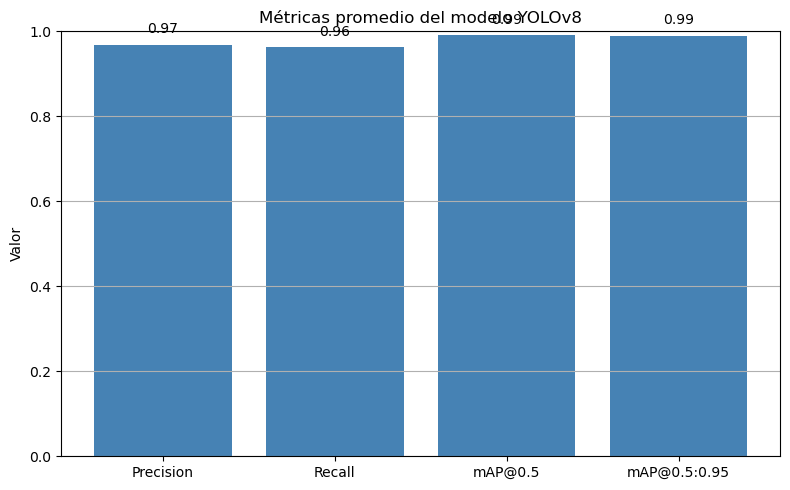

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Asegurar que matplotlib use el backend correcto (útil en notebooks)
%matplotlib inline

# Extraer métricas por clase desde metrics.box
precision = np.mean(metrics.box.p)
recall = np.mean(metrics.box.r)
map50 = np.mean(metrics.box.ap50)
map5095 = np.mean(metrics.box.ap)

# Nombres y valores
names = ["Precision", "Recall", "mAP@0.5", "mAP@0.5:0.95"]
values = [precision, recall, map50, map5095]

# Graficar
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(names, values, color='steelblue')
ax.set_ylim(0, 1)
ax.set_title("Métricas promedio del modelo YOLOv8")
ax.set_ylabel("Valor")
ax.grid(axis="y")

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


En el conjunto de validación compuesto por 1090 imágenes, el modelo consiguio precisión (Precision): 96.8%

Estas métricas reflejan que, a pesar de haber sido entrenado por solo 10 épocas, el modelo es altamente eficaz para tareas de detección de objetos y tiene un excelente potencial de generalización.

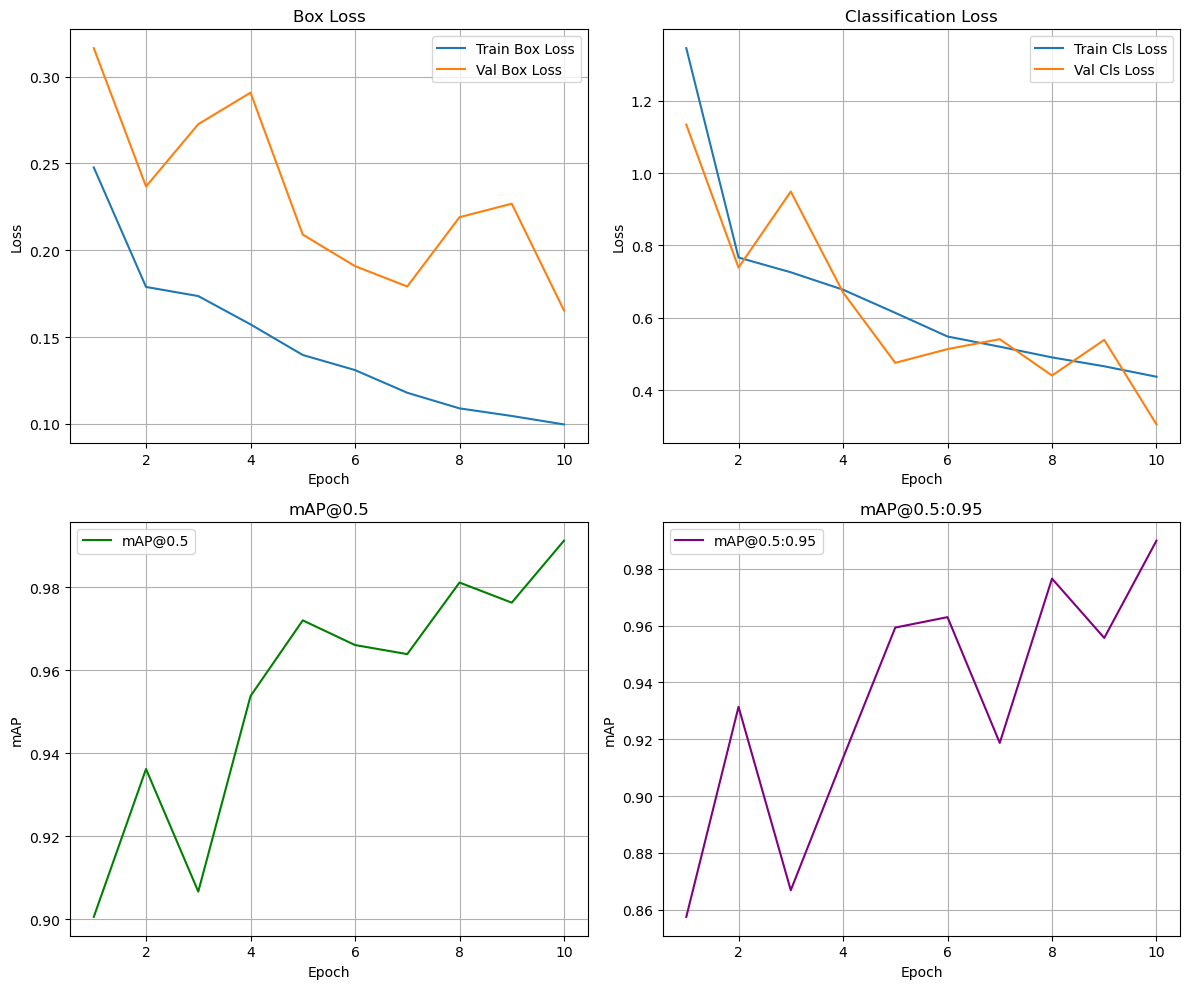

In [30]:
import matplotlib.pyplot as plt

# Gráfica de métricas de entrenamiento y validación
plt.figure(figsize=(12, 10))

# Box Loss
plt.subplot(2, 2, 1)
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.title('Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Classification Loss
plt.subplot(2, 2, 2)
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# mAP@0.5
plt.subplot(2, 2, 3)
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', color='green')
plt.title('mAP@0.5')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid()

# mAP@0.5:0.95
plt.subplot(2, 2, 4)
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='purple')
plt.title('mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


En las gráficas superiores se observan las pérdidas de caja (box loss) y clasificación (cls loss), tanto en entrenamiento como en validación. En ambos casos, se aprecia una tendencia decreciente, lo cual es una buena señal de convergencia del modelo, aunque con cierta fluctuación en la validación, posiblemente por el tamaño limitado del dataset.

En la parte inferior se visualizan las métricas de precisión media: mAP@0.5 y mAP@0.5:0.95. Ambas muestran una clara mejora a lo largo de las épocas, alcanzando valores superiores al 0.98 al final del entrenamiento, lo que indica una excelente capacidad del modelo para detectar objetos correctamente tanto a umbrales bajos como más exigentes de IoU.

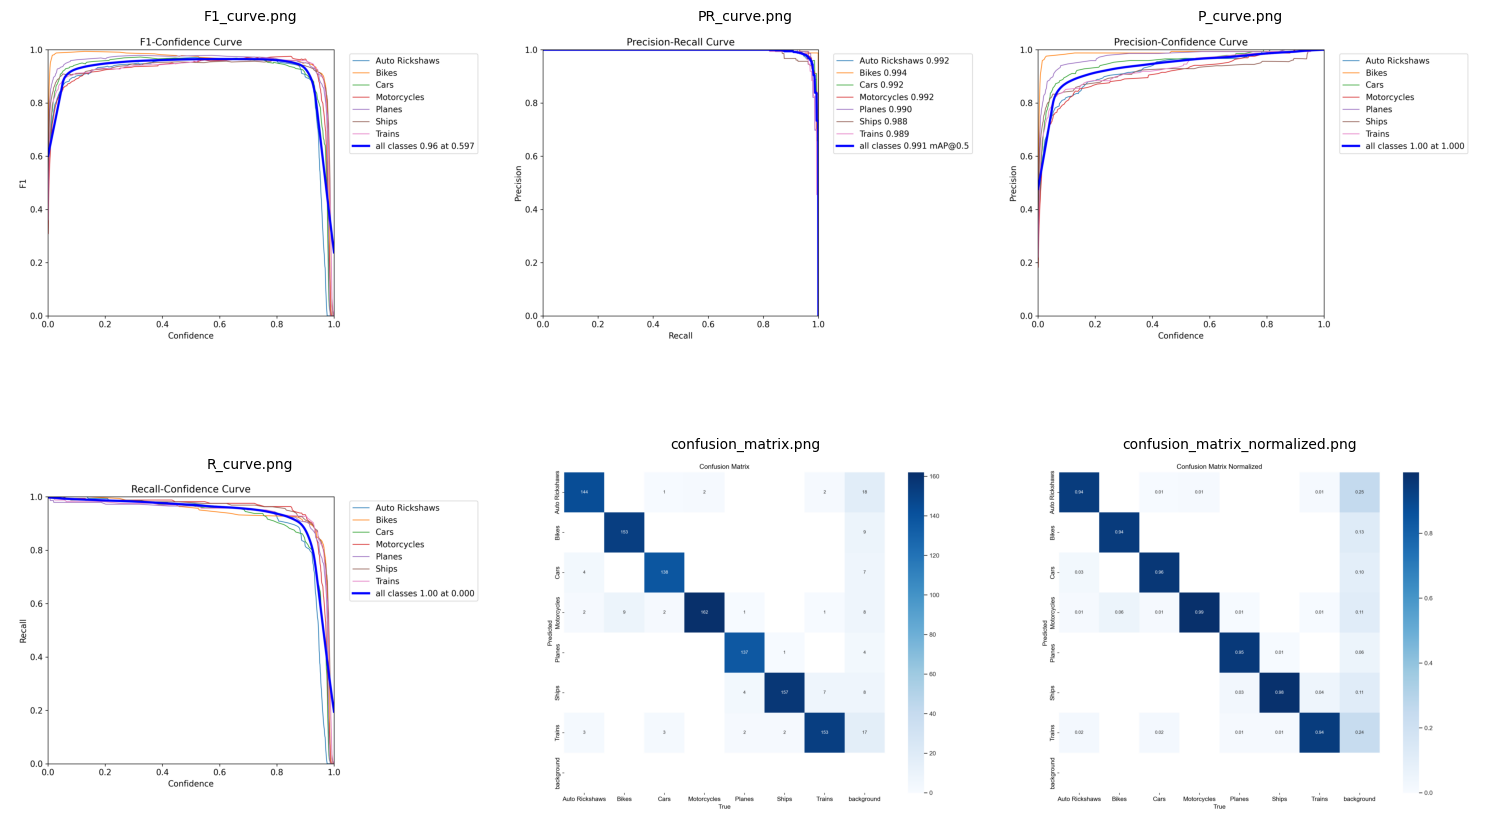

In [ ]:

from PIL import Image

# Ruta y carga de imágenes
folder_path = "runs/detect/val"
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg'))])

# Primeras 6 imágenes
first_six = image_files[:6]

# Mostrar
plt.figure(figsize=(15, 10))
for i, image_name in enumerate(first_six):
    image_path = os.path.join(folder_path, image_name)
    img = Image.open(image_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(image_name, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


Aunque se han generado varias gráficas durante la evaluación del modelo, en este apartado se comentan brevemente dos de las más representativas.

La primera es la matriz de confusión normalizada, que muestra el desempeño del modelo clasificando correctamente cada categoría de objeto. Se observa una alta precisión generalizada, con valores cercanos o superiores al 94% en las clases principales. No obstante, algunas clases como “Auto Rickshaws” o “Trains” muestran ligeras confusiones.

La segunda es la curva de Precisión-Confianza, la cual representa cómo varía la precisión del modelo en función del nivel de confianza de sus predicciones.  La curva general, así como las curvas individuales por clase, se mantienen altas

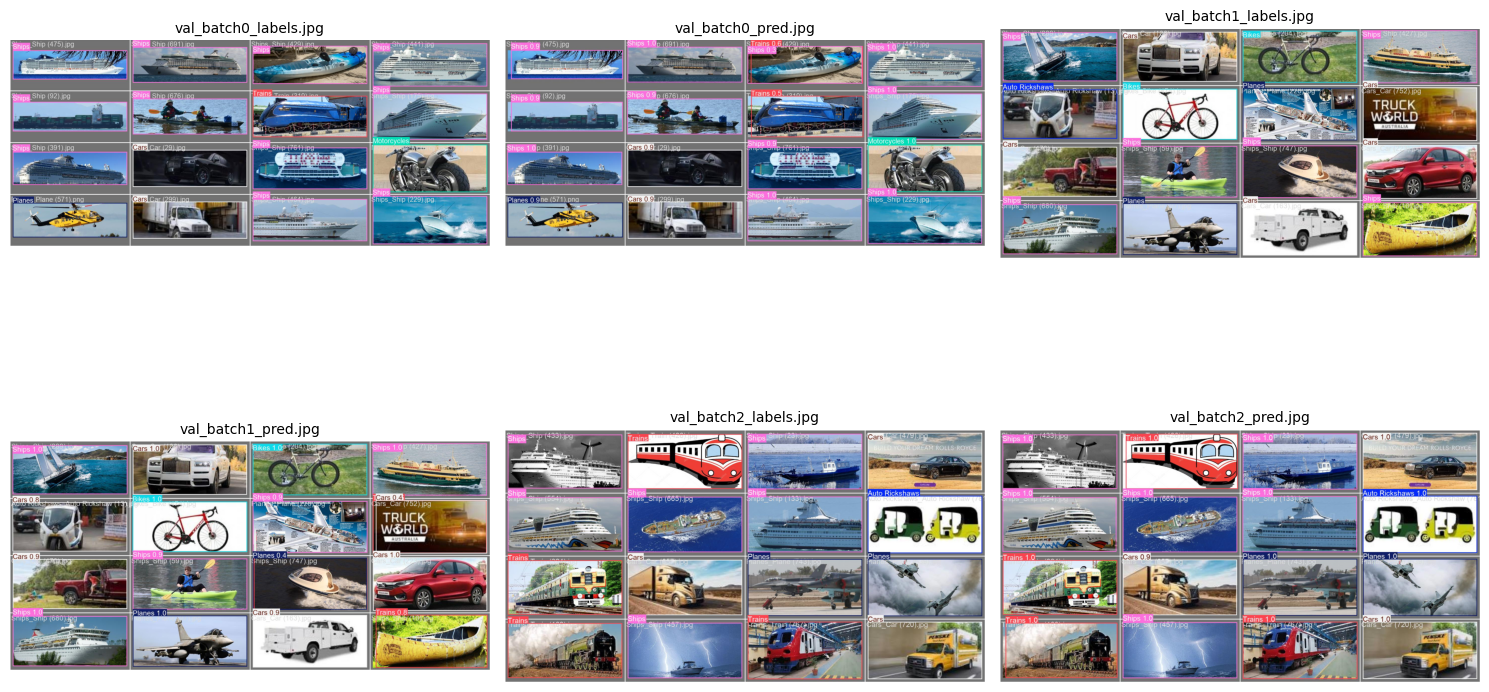

In [33]:
# Siguientes 6 imágenes
next_six = image_files[6:12]

# Mostrar
plt.figure(figsize=(15, 10))
for i, image_name in enumerate(next_six):
    image_path = os.path.join(folder_path, image_name)
    img = Image.open(image_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(image_name, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


Ejemplos de imágenes utilizadas durante el entrenamiento del modelo, donde cada una contiene un único objeto centrado, y se asignó una anotación simplificada que abarca toda la imagen

### Pruebas cualitativas con imágenes externas 


image 1/1 /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/RealImageTest/fredrick-f-nRR_wCiH4GQ-unsplash.jpg: 480x640 1 Ships, 98.1ms
Speed: 2.8ms preprocess, 98.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


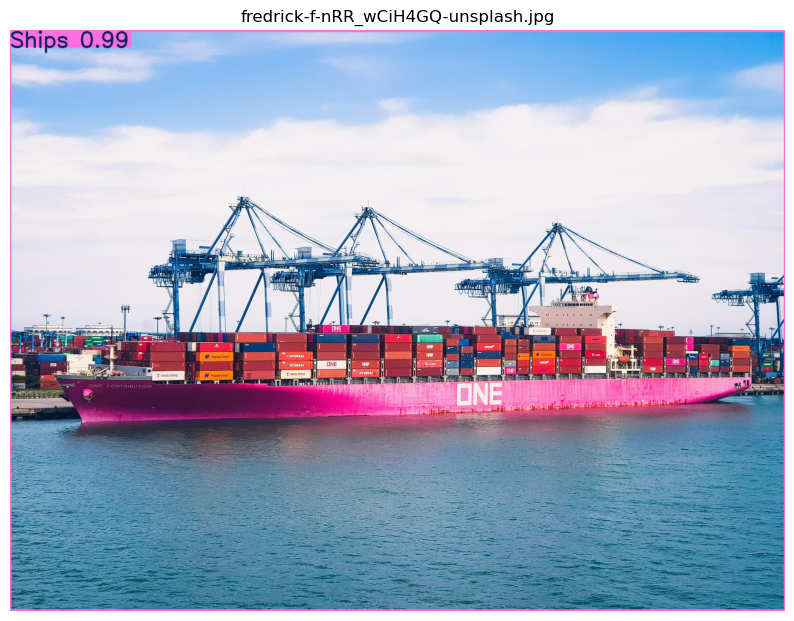


image 1/1 /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/RealImageTest/dan-gold-N7RiDzfF2iw-unsplash.jpg: 384x640 1 Cars, 81.9ms
Speed: 2.0ms preprocess, 81.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


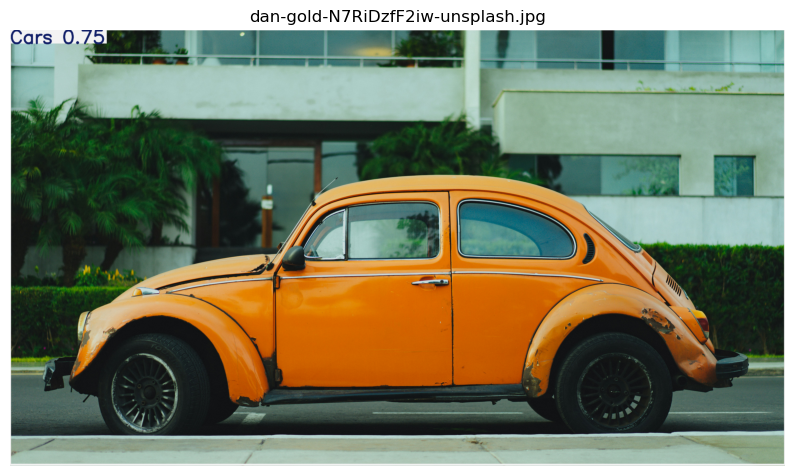


image 1/1 /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/RealImageTest/y-s-vqXLFIwn-bI-unsplash.jpg: 512x640 1 Planes, 101.8ms
Speed: 3.0ms preprocess, 101.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


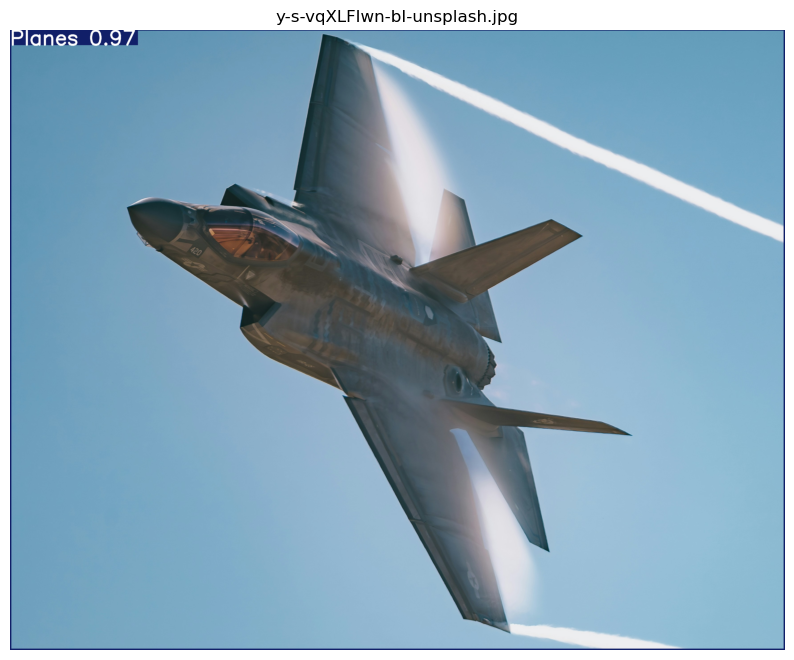


image 1/1 /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/RealImageTest/leonie-clough-CuZATeqXD4w-unsplash.jpg: 416x640 1 Auto Rickshaws, 86.0ms
Speed: 2.2ms preprocess, 86.0ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


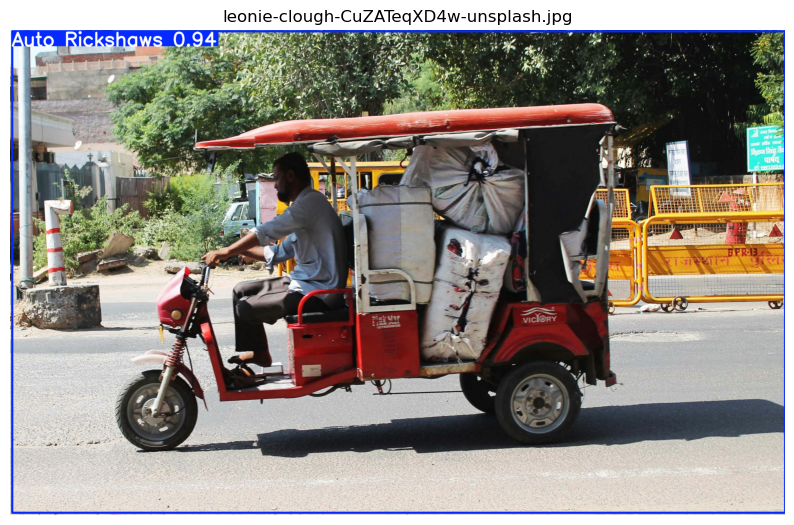


image 1/1 /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/RealImageTest/joba-khan-f1nMQWwr4hM-unsplash.jpg: 480x640 1 Motorcycles, 1 Ships, 91.6ms
Speed: 2.3ms preprocess, 91.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


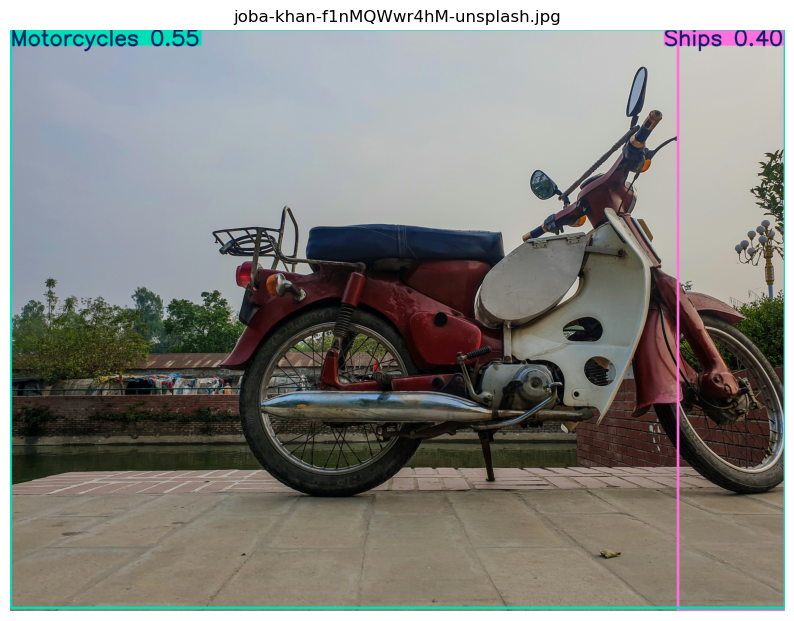


image 1/1 /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/RealImageTest/daria-kraplak-N7bruK4454k-unsplash.jpg: 448x640 1 Trains, 89.1ms
Speed: 2.3ms preprocess, 89.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


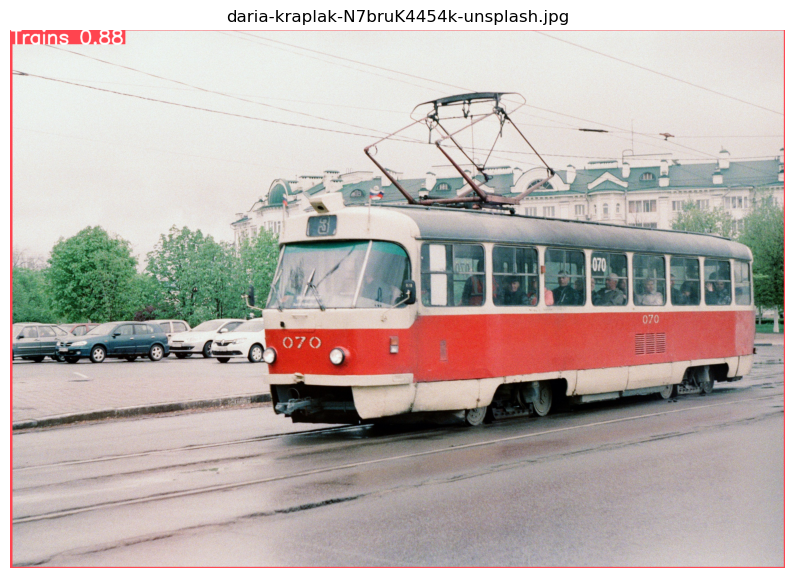


image 1/1 /Users/javi/Desktop/PostGRADO/ICAI_MASTER/Semestre2/Analisis_DatosNoStructurados/PRACTICAS/ImagenPractica/RealImageTest/gentrit-murati-n1muI8uMdG0-unsplash.jpg: 480x640 1 Ships, 100.1ms
Speed: 2.7ms preprocess, 100.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


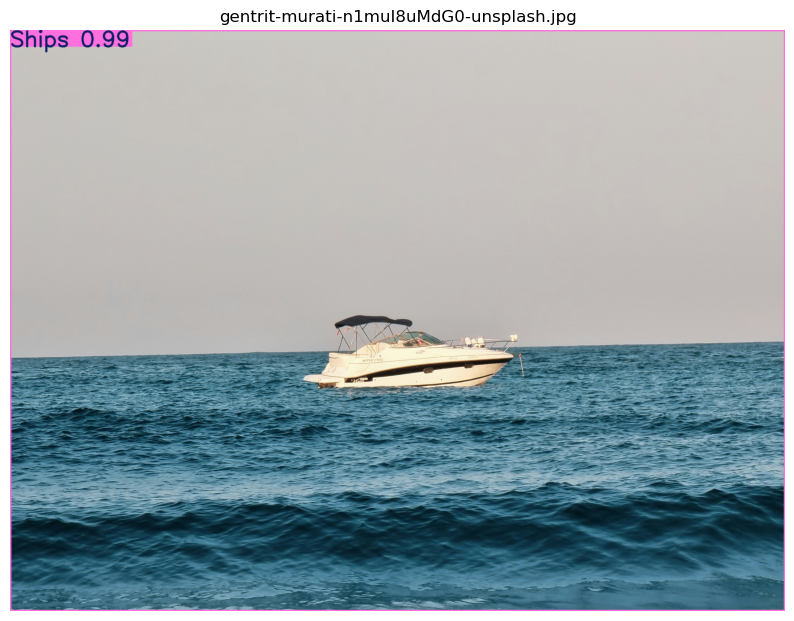

In [45]:
# Ruta a imágenes
from pathlib import Path
image_dir = Path("RealImageTest")
image_paths = list(image_dir.glob("*.jpg"))

# Detección
for path in image_paths:
    results = model(path)
    im_bgr = results[0].plot()  # Imagen con detecciones
    
    # Convertir BGR a RGB para mostrar con matplotlib
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    
    # Mostrar
    plt.figure(figsize=(10, 10))
    plt.imshow(im_rgb)
    plt.title(path.name)
    plt.axis('off')
    plt.show()

### Conclusiones


En la fase final de este proyecto, se realizaron pruebas cualitativas con imágenes externas no utilizadas durante el entrenamiento. El objetivo fue evaluar visualmente la capacidad del modelo para detectar objetos reales como barcos, motocicletas y otros vehículos en contextos naturales. A pesar de que los resultados muestran una detección razonablemente buena (por ejemplo, identificando un barco con una confianza del 99%) se observan ciertos errores en otras predicciones, como una motocicleta que fue parcialmente identificada también como un barco.

Es importante destacar que estas limitaciones se deben en gran parte a la forma en que se generaron las anotaciones de entrenamiento: de manera artificial, asignando una caja que abarca toda la imagen sin precisar la forma exacta del objeto. Como resultado, aunque el modelo ha aprendido a reconocer clases, su precisión espacial en la delimitación de objetos no es óptima.

Como pasos futuros, se recomienda anotar manualmente los objetos con bounding boxes precisas y utilizar imágenes más variadas y complejas para mejorar la generalización del modelo en contextos reales.